# Numerical determination of $\sigma_0$

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import sys
import os,glob
import yaml
from chainconsumer import ChainConsumer
from scipy.special import gamma
from scipy.optimize import fsolve
from scipy.interpolate import interp1d  

In [2]:
npows = [0]
masses_test = [1e-5,1e-4,1e-3,1e-2,1e-1,1.,10.,100.]
sigmas_test = np.logspace(-26,-30,20)

## Relevant functions

In [190]:
def calculate_kcuts(npow=0, m=1e-3, z='z1',sigmas=sigmas_test,
           pk_root='class/pk_output/', upper_cut=66, lower_cut=1, reduction_factor=0.75):
    
    data0 = np.loadtxt(pk_root + 'lcdm_{}_pk.dat'.format(z))
    ks = data0[:,0]
    pk0 = data0[:,1]
    
    khms = []
    ss = []
    for i,sigma in enumerate(sigmas):
        filename = pk_root + 'n{}_m{}_s{}_{}_pk.dat'.format(npow,m,sigma,z)

        data = np.loadtxt(filename)
        pk = data[:,1]
   
        ind = (np.abs(np.abs((pk0-pk)/pk0) - reduction_factor)).argmin()
        if ks[ind]>upper_cut or ks[ind]<lower_cut:
            continue
        khms.append(ks[ind])
        ss.append(sigmas[i])
    
    try:
        p = np.polyfit(np.log10(ss), np.log10(khms), 1)
    except:
        return -1
    
    plt.loglog(khms,ss)
    return np.array(ss),np.array(khms),p

In [191]:
def fit_fun(x,p):
    pp = p[0]*np.log10(x) + p[1]
    return np.power(10,pp)

In [192]:
def sigma0_limit(kcut, masses=masses_test,
                npow=0, z=0,reduction_factor=0.25,
                ymax=1e-26,ymin=1e-31,plot_ks=True):
    
    masses = np.array(masses)
    sigmas = np.zeros(len(masses))

    for i,m in enumerate(masses):
        ks_filename = 'data/ks_{}_z{}_n{}_m{}.txt'.format(reduction_factor,z,npow,m)
        data = np.loadtxt(ks_filename)
        ss = data[:,0]
        ks = data[:,1]
        p = np.polyfit(np.log10(ks), np.log10(ss), 1)
        sigmas[i] = fit_fun(kcut,p)
        
    plt.loglog(masses,sigmas)
          
    return masses,sigmas

In [193]:
def show_pk(npow=0,m=0.01,sigmas=sigmas_test,z='z1',
           pk_root='class/pk_output/',
            filename=None,lcdm_filename='lcdm_z1_pk.dat',label='',
           f=None,ax=None,xmin=0,xmax=20,ymin=-1.0,ymax=1e3,
           show_kcut=True,pfit=None, relative=True,boost_factor=1.):
        
    data0 = np.loadtxt(pk_root + lcdm_filename)
    ks = data0[:,0]
    pk0 = data0[:,1]
    
    if filename is None:
        for i,sigma in enumerate(sigmas):
            filename = pk_root + 'n{}_m{}_s{}_{}_pk.dat'.format(npow,m,sigma,z)
            data = np.loadtxt(filename)
            pk = data[:,1]
            plt.semilogx(ks,(pk)/pk0,label=r'{}cm$^2$'.format(sigma))
            plt.axvline(x=36,color='k')
            
    plt.xlabel('k [1/Mpc]')
    plt.ylabel('P(k) residual')
    plt.xlim(1e-5,1e5)
    plt.show()

---

In [199]:
npow_=0

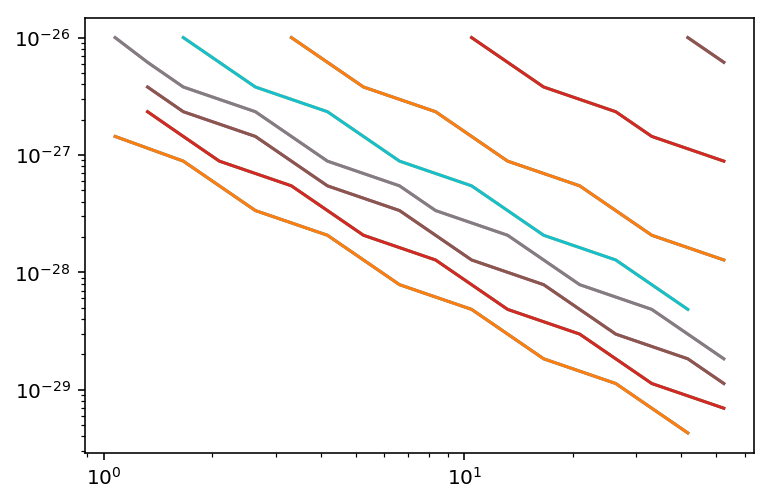

In [200]:
for m in masses_test:
    if calculate_kcuts(npow=npow_, m=m, z='z1') == -1:
        continue
    sigmas, kcuts, p = calculate_kcuts(npow=npow_, m=m, z='z1')

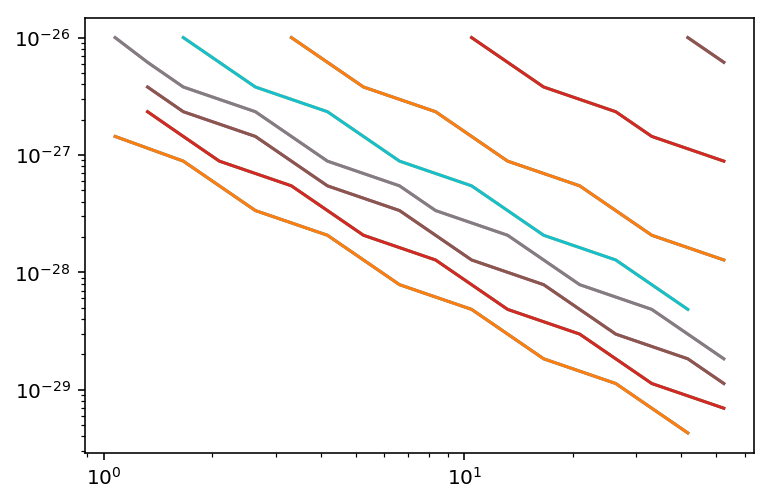

In [201]:
sigmas_ref = np.logspace(-23,-33,1000)
for m in masses_test:
    ks_filename = 'data/ks_0.25_z0_n0_m{}.txt'.format(m)
    if calculate_kcuts(npow=npow_, m=m, z='z1') == -1:
        continue
    sigmas, kcuts, p = calculate_kcuts(npow=npow_, m=m, z='z1')
    ks = fit_fun(sigmas_ref,p)
    np.savetxt(ks_filename, np.vstack((sigmas_ref, ks)).T)

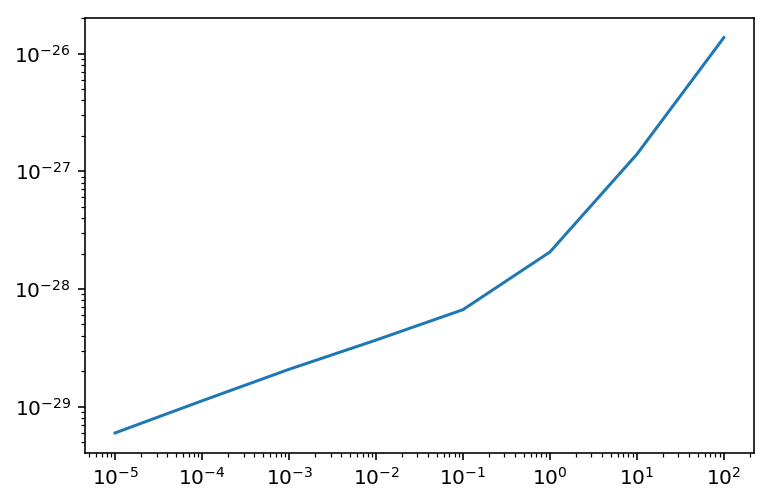

In [202]:
masses,sigmas=sigma0_limit(kcut=36,npow=npow_)

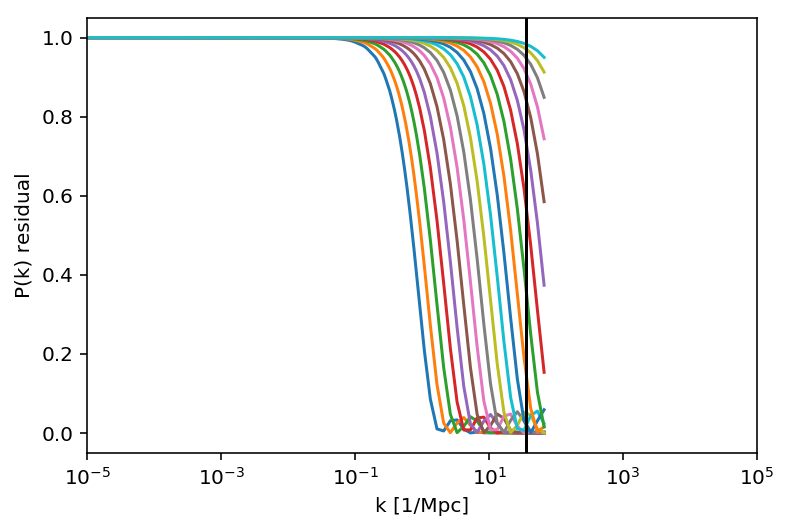

In [203]:
show_pk(npow=npow_)